# Working with real SPDs

Data from:
Royer, Michael (2020). Real Light Source SPDs and Color Data for Use in Research. figshare. Dataset. https://doi.org/10.6084/m9.figshare.12947240.v2 

Converted to an Excel file by the author of this notebook.

In [1]:
import matplotlib.pyplot as plt
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors
from luxpy.color.utils import plot_cmfs, plot_color_data
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict
from luxpy.spectrum import spd_to_xyz

from empir19nrm02 import _SPD, _RES
from empir19nrm02.tools.help import display_color_diagram, display_spectra, save_fig
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, get_target, label_management, \
    quantil, display_responsivity, get_fig_file_name

print('Version of luxpy:', lx.__version__)
out_dir = 'RealSPD'

import os
print( 'CWD:', os.getcwd())

E:\TTBV\Python\luxpy\luxpy\spectrum\basics\illuminants.py:512: RankWarning: Polyfit may be poorly conditioned
  xy, pxy, pxT_l7, pxT_L7, l7, L7 = _get_daylightlocus_parameters(ccts, spds, cieobs_)


Version of luxpy: v1.10.0
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
# Load the data from the file data\SPD\RealSPDs_DB.xlsx
import pandas as pd

# get all entries of a column but without duplicates
def getUnique(dfTmp, colName):
    return dfTmp[colName].unique()

def getDBandSPD( file):
    # generate an array of SPDs (necessary to take the different wavelength ranges into account)
    SPDs = []

    xls = pd.ExcelFile(file)
    # make a database from the workbook 'SPDs'
    # use the first row as header  
    df = xls.parse('SPDs', header=1)

    # convert all data to SPD instances
    for i in range(0, df.shape[0]):
        # read the wavelength range for the current line
        lambdaMin = df.loc[i, 'Start Wavelength']
        lambdaMax = df.loc[i, 'End Wavelength']
        lambdaStep = df.loc[i, 'Interval']
        # extract the spectral data
        spd = df.loc[i, 'Spectral Data':]
        # generate the np array (with limited entries)
        npSPD = np.array(spd)[1:int((lambdaMax-lambdaMin)/lambdaStep+2)]
        # generate the wl range
        wl = np.arange(lambdaMin, lambdaMax+lambdaStep, lambdaStep)
        # generate the SPD object
        lxSPD = lx.SPD(spd=np.vstack([wl, npSPD]))
        # add the current SPD to the list
        SPDs.append(lxSPD)

    
    # delete all columns from the DB after the Interval column 
    df = df.loc[:, 'Technology':'Interval']
    # Add a column with Number of dataset and define the columnname as 'Number', make it the first column
    df.insert(0, 'Number', range(0, df.shape[0]))
    #df['Number'] = range(0, df.shape[0])
    
    
    dfPerformance = xls.parse('Performance Data', header=1)
    dfPerformance = dfPerformance.iloc[:, 11:69]
    dfAll = pd.concat([df, dfPerformance], axis=1)
    
    return dfAll, SPDs 

df, SPDs = getDBandSPD('../data/SPD/RealSPDs_DB.xlsx')    

print(df.shape)
print(len(SPDs))


(1522, 68)
1522


In [3]:
# get all entries of a column but without duplicates
print(getUnique(df, 'Technology'))
print(getUnique(df, 'Technology Sub Type'))
#print(getUnique(df, 'Product/ Description'))
#print(getUnique(df, 'Obtained From'))

['Fluorescent' 'HID' 'Incandescent/Filament' 'Laser Diode' 'LED' 'OLED'
 'Other' 'Plasma']
['Broadband' 'Narrowband' 'HPS' 'Mercury' 'MH' 'Filtered' 'Halogen'
 'Krypton' 'Neodymium' 'Other' 'Standard' nan 'CM' 'HY' 'PC' 'PC-NR'
 'PC-Filter' 'UN']


Fluorescent 73
25 1.0
45 1.0
54 1.0
28 0.9999999999590727
42 0.9999999998299245
67 1.0
63 0.9999999999837996
32 1.000000000084924
11 1.0
62 1.000000000032685
['Fluorescent']


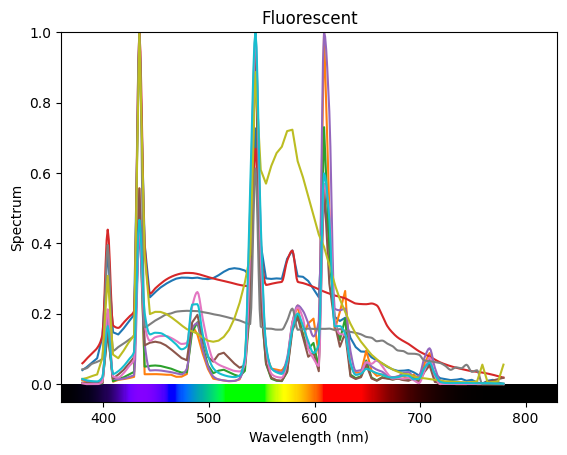

HID 36
80 1.0000000000067075
105 1.0
89 1.0
73 1.0
95 1.0
77 1.0
83 0.9999999999793658
107 1.0
98 1.0
75 1.0
['HID']


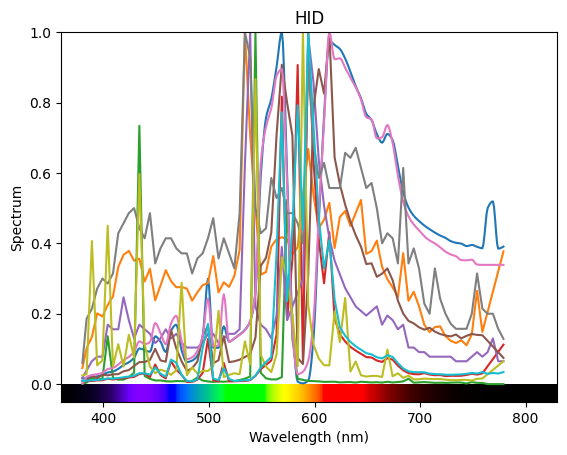

Incandescent/Filament 26
117 1.000000000000731
109 1.0
124 1.0000000000001474
130 0.9999999999996083
134 0.9999999999999961
127 1.0000000000000022
118 1.0
133 1.0
121 1.0005399999999751
111 1.0
['Incandescent', 'Filament']


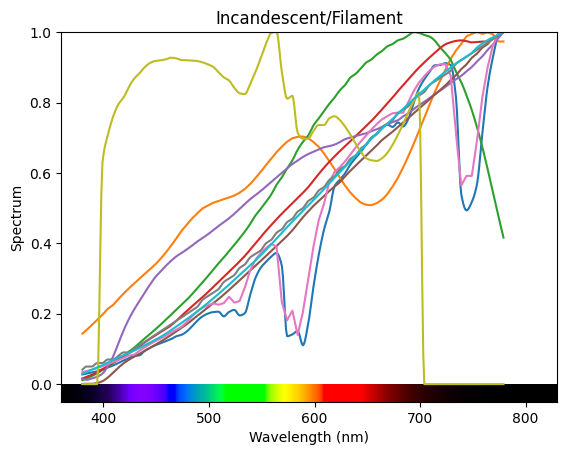

Laser Diode 9
137 0.7263
135 0.8093
139 0.9253
141 0.9185
142 0.8857
140 0.9441
136 0.9579
143 1.0
138 0.8297
['Laser Diode']


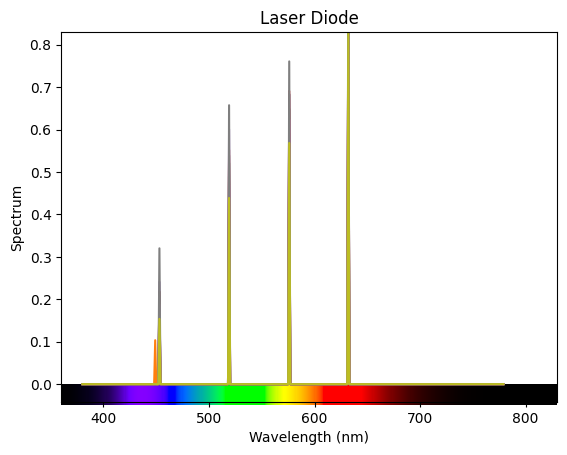

LED 1370
1127 1.0
1509 0.9999999999996021
1334 0.047016
838 0.67488102664861
1188 1.0
486 0.9999999999992628
1413 1.0
1017 1.0
164 1.000000000010914
1369 1.0
['LED']


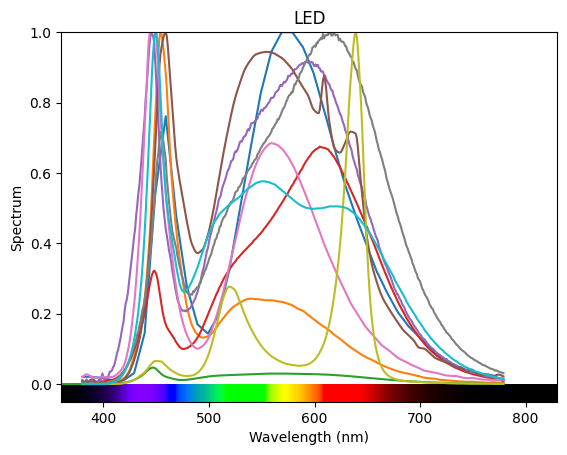

OLED 5
1514 1.0000000000015739
1515 1.0000000000016396
1518 1.0
1517 0.999999999999607
1516 1.0000000000000653
['OLED']


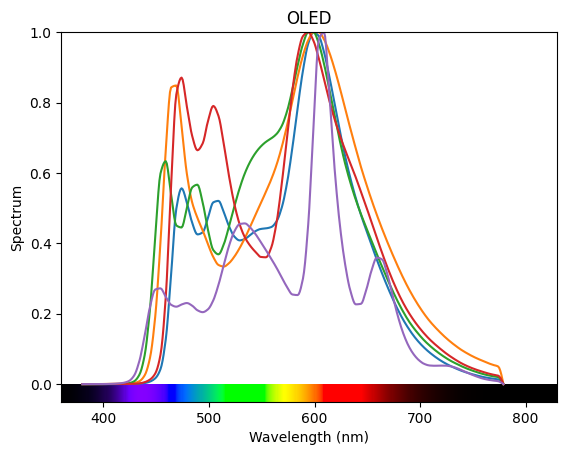

Other 2
1519 0.9999999999999201
1520 1.0000000000001492
['Other']


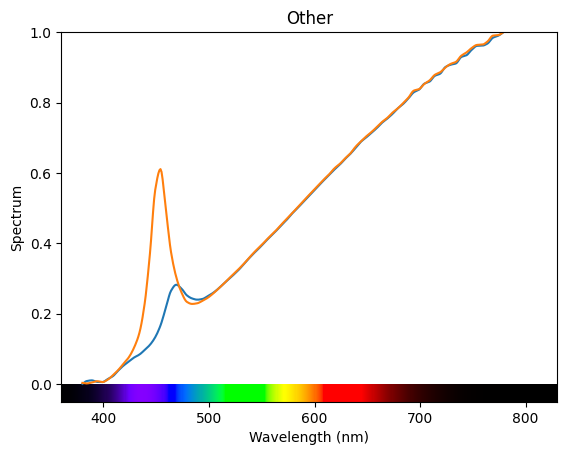

Plasma 1
1521 1.0
['Plasma']


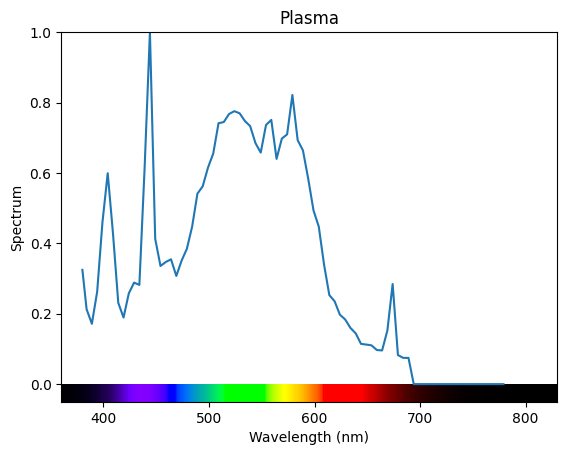

In [8]:
# Qurey the database for a specific technology
def queryDB(df, tech):
    return df.loc[df['Technology'] == tech]

maxPlots = 10

for tech in getUnique(df, 'Technology'):
    dfq = queryDB(df, tech)
    print(tech, dfq.shape[0])
    # choose randomly maxPlots entries from the database
    dfq = dfq.sample(n=min(maxPlots, dfq.shape[0]))   
    for i in range(0, dfq.shape[0]):
        spdIndex = dfq.iloc[i]['Number']
        print( spdIndex, max(SPDs[spdIndex].value[0]) )
        SPDs[spdIndex].plot()
    plt.title(tech)
    splited = tech.split('/')
    print(splited)
    save_fig(dir=out_dir, filename=splited[0])        
